In [1]:
###This metric shows the number of toxic messages per month for a user in a repo###
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import datetime
import json
warnings.filterwarnings('ignore')

with open("config.json") as config_file:
    config = json.load(config_file)

database_connection_string = 'postgres+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
###USER PICKS REPO TO MEASURE THIS METRIC###
repoName = input("input repo name:")

input repo name: Loris


In [4]:
### USER PICKS SPECIFIC CONTRIBUTER TO MEASURE THIS METRIC###
cntrbID = input("input contributer name:")

input contributer name: 389737


In [5]:
###This gathers the average sentiment scores for every message in the history of the repo and orders them by month###
repolist = pd.DataFrame()

repo_query = salc.sql.text(f"""
            SELECT
                repo.repo_id,
                repo.repo_name,
                date_trunc( 'month', message.msg_timestamp ) AS message_month,
                message.cntrb_id, 
                AVG ( message_analysis.sentiment_score ) AS average_sentiment
            FROM
                repo, message_analysis, message, issue_message_ref, issues 
                where message_analysis.msg_id = message.msg_id 
                and 
                issue_message_ref.issue_id = issues.issue_id  
                AND
                issue_message_ref.msg_id = message.msg_id 
                AND
                issues.repo_id = repo.repo_id 
                AND
                repo.repo_name = '""" + repoName + """'
                AND
                message.cntrb_id = '""" + cntrbID + """'
                
            GROUP BY
                repo.repo_id,
                repo.repo_name,
                message.msg_timestamp, 
                message.cntrb_id 
            ORDER BY
                message_month ASC,
                average_sentiment DESC,
                repo_id;
    """)

repolist = pd.read_sql(repo_query, con=engine)
print("SQL Query Complete")

SQL Query Complete


In [6]:
###This gathers all the possible months to be used for calculating percentages###
repolist2 = pd.DataFrame()

repo_query2 = salc.sql.text(f"""
            SELECT DISTINCT
                repo.repo_id,
                repo.repo_name,
                date_trunc( 'month', message.msg_timestamp ) AS message_month
            FROM
                repo, message_analysis, message, issue_message_ref, issues 
                where message_analysis.msg_id = message.msg_id 
                AND
                issue_message_ref.issue_id = issues.issue_id  
                AND
                issue_message_ref.msg_id = message.msg_id 
                AND
                issues.repo_id = repo.repo_id 
                AND
                repo.repo_name = '""" + repoName + """'
                AND
                message.cntrb_id = '""" + cntrbID + """'
            GROUP BY
                repo.repo_id,
                repo.repo_name, 
                message.msg_timestamp
            ORDER BY
                message_month;
    """)

repolist2 = pd.read_sql(repo_query2, con=engine)
print("SQL Query Complete")

SQL Query Complete


In [7]:
###This calculates the percent of toxic messages per month and stores each month's average in an array###
toxic_messages_by_month_array = np.zeros(len(repolist2.message_month))
monthYearLabel = []
i = 0
j = 0
print("Data Tabulation Started...")
while i < len(repolist2.message_month):
    month = repolist2.message_month[i]
    toxic_messages = 0
    total_messages = 0 #total messages for each month
    while repolist.message_month[j] == month:
        if repolist.average_sentiment[j] < 0:
            toxic_messages = toxic_messages + 1
        total_messages = total_messages + 1
        j = j + 1
        if j >= len(repolist.message_month):
            break
    toxic_messages_by_month_array[i] = toxic_messages
    monthYearLabel.append(repolist2.message_month[i].to_pydatetime().strftime("%B %Y"))
    #print("toxic messages for month:", monthYearLabel[i], ":",  toxic_messages, "total messages:", total_messages)
    i = i + 1
print("Data Tabulation Complete")

Data Tabulation Started...
Data Tabulation Complete


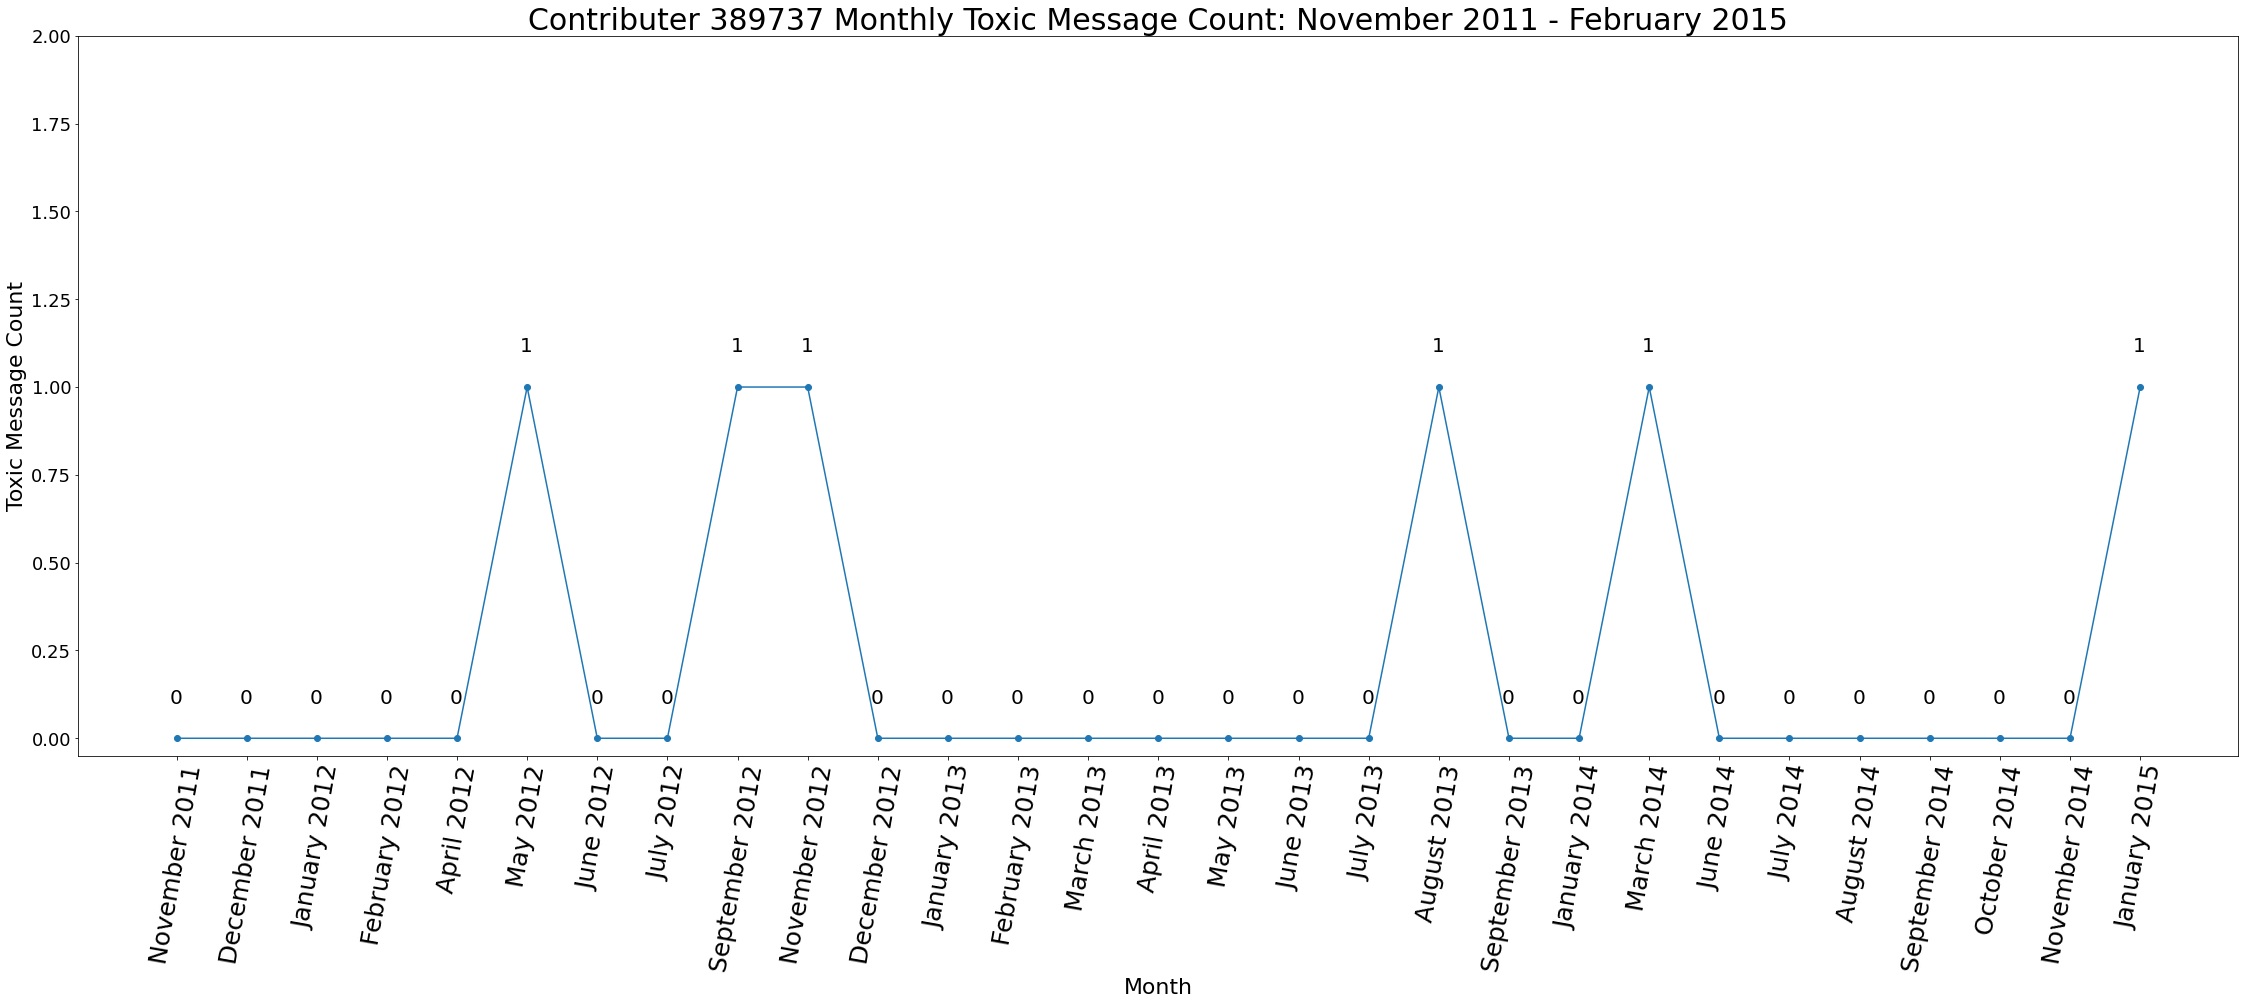

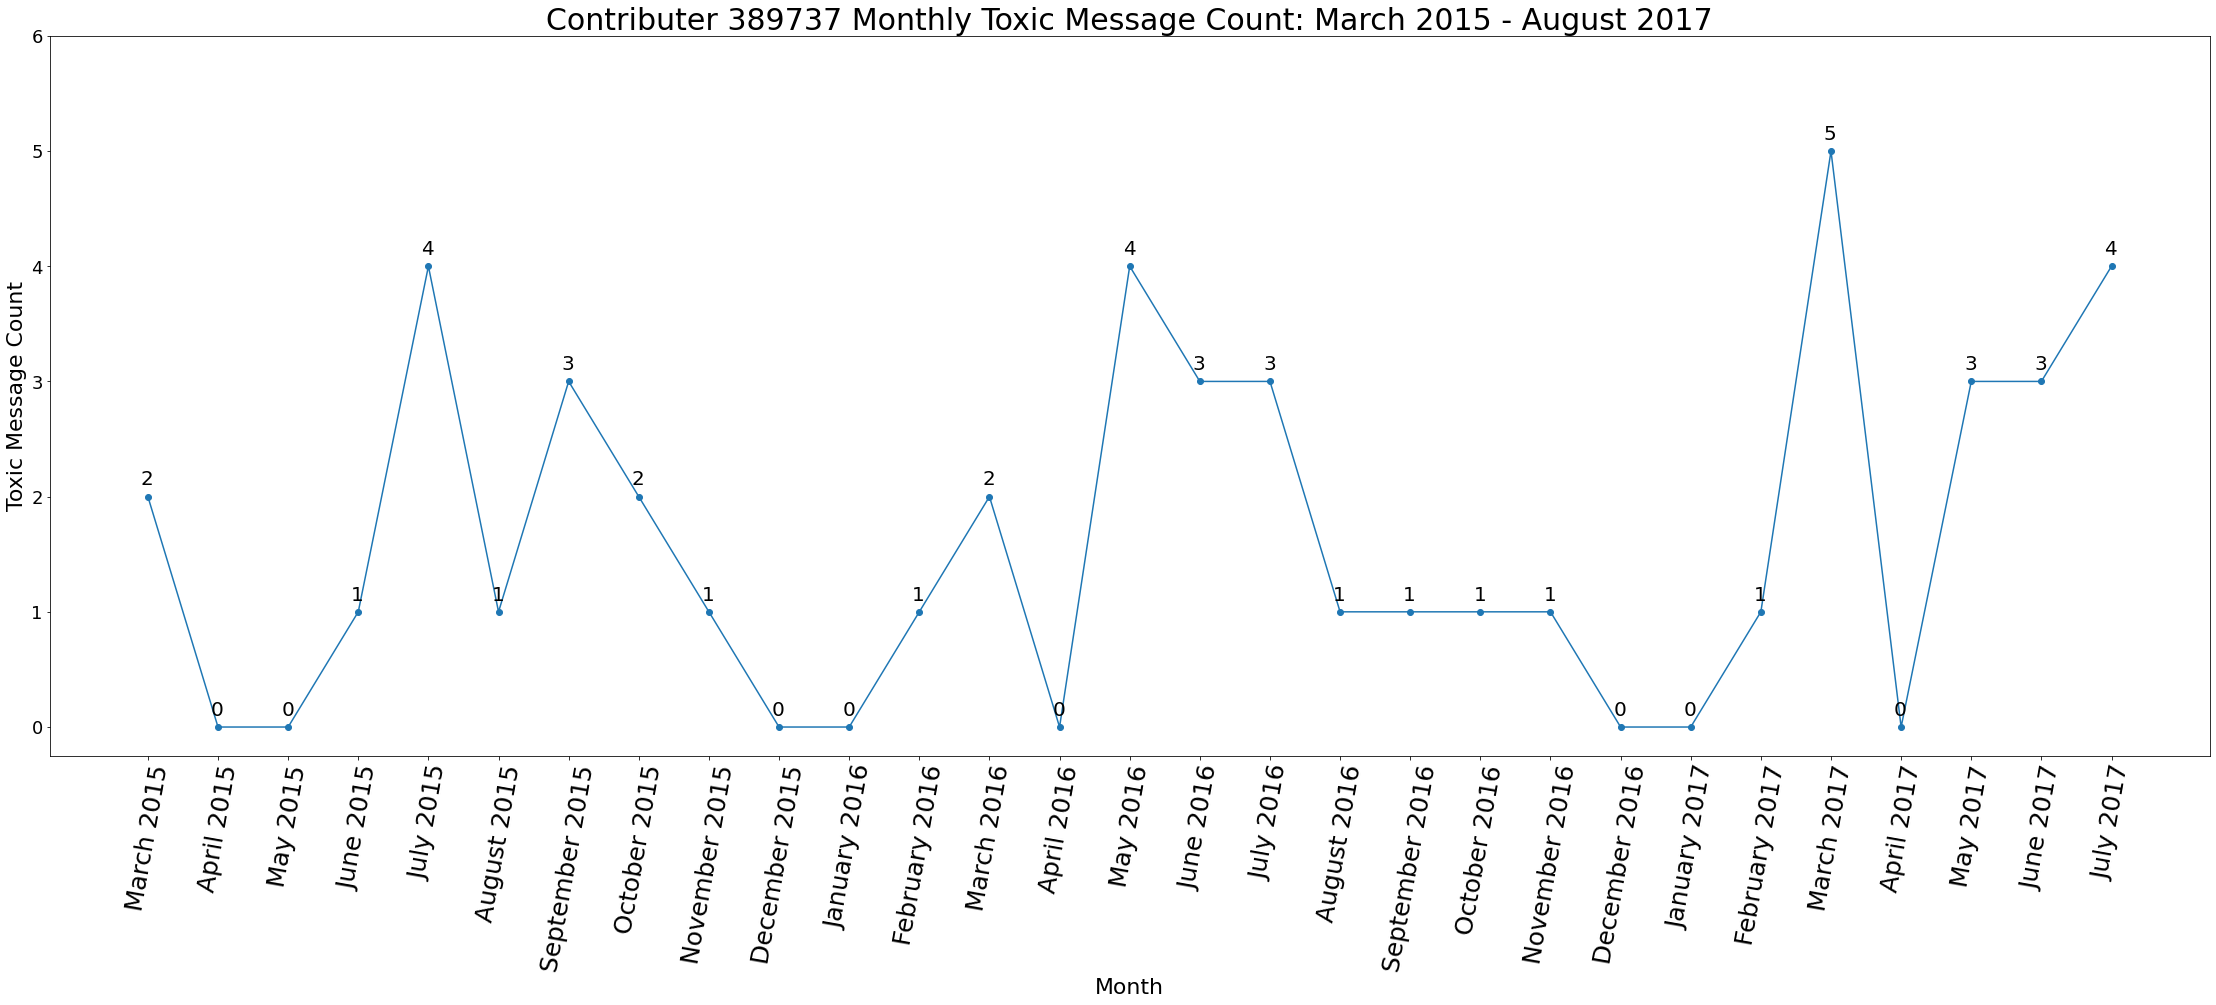

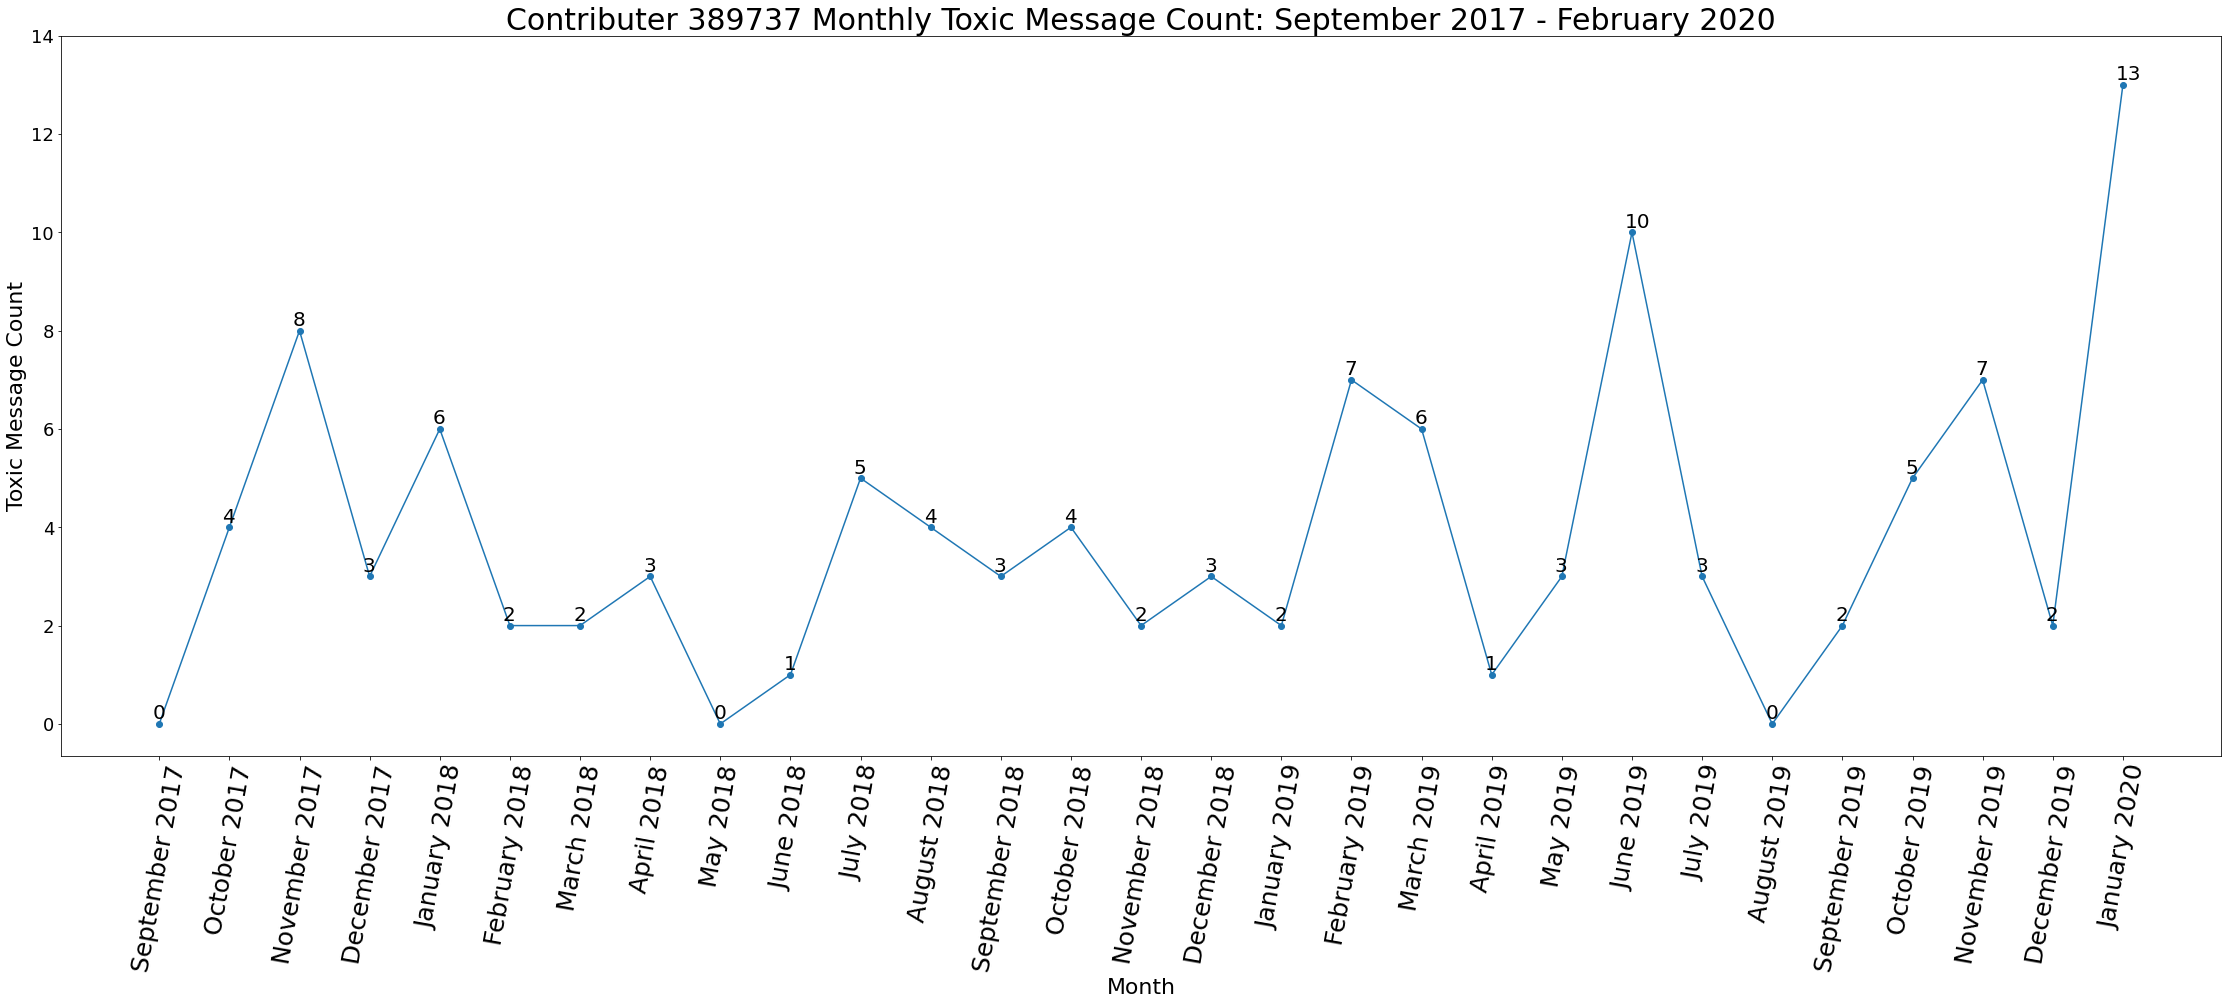

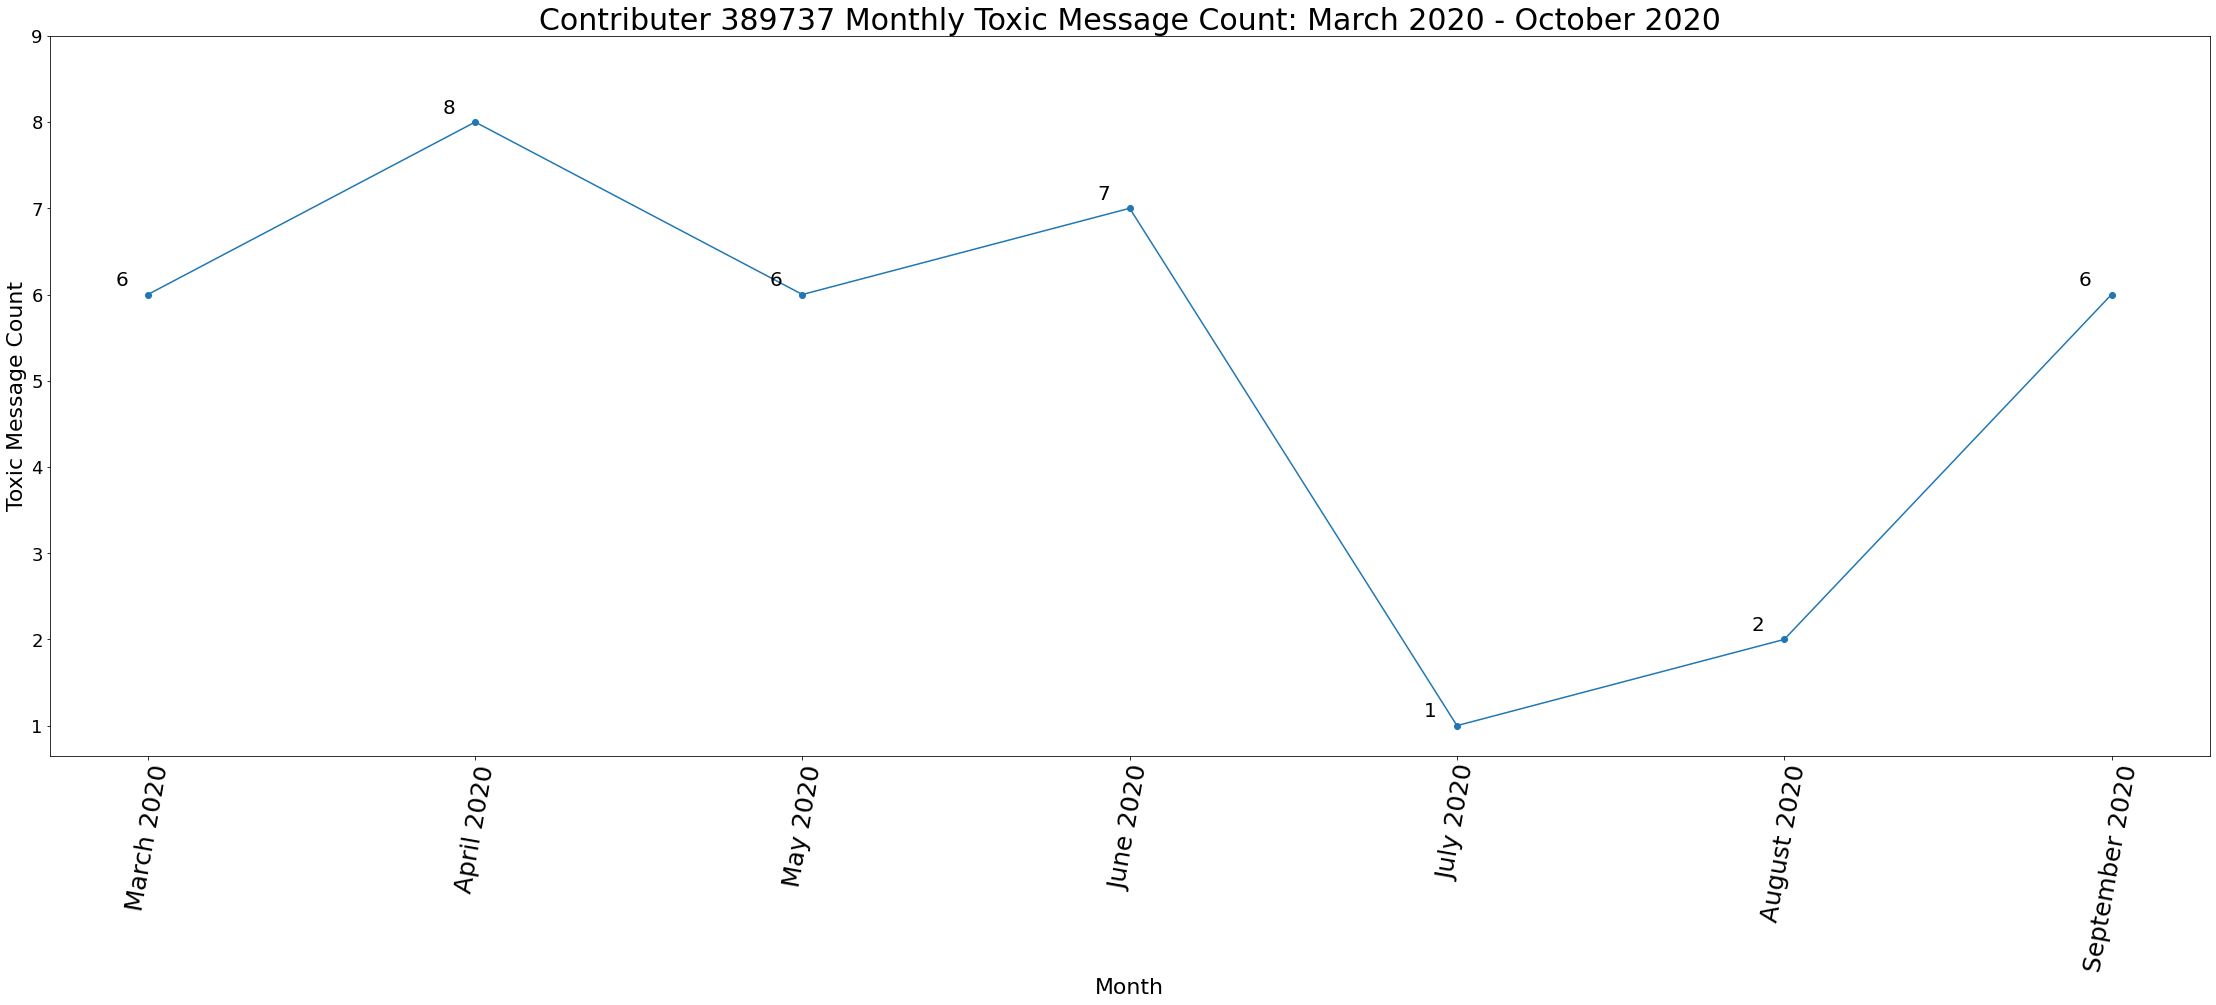

In [8]:
###This plots the number of toxic messages per month
x = list(range(len(toxic_messages_by_month_array)))
y = toxic_messages_by_month_array

length = len(monthYearLabel)
lower = 0;
upper = min(29, length)
while(upper < len(toxic_messages_by_month_array)):
    if(lower > upper or lower >= length):
        break
    X = np.arange(len(x[lower:upper]))
    fig = plt.figure(figsize=(30, 10))
    ax = fig.add_axes([0,0,1,1])
    graph = plt.scatter(x[lower:upper], y[lower:upper])
    plt.plot(x[lower:upper],y[lower:upper])
    plt.xticks(x[lower:upper], monthYearLabel[lower:upper], rotation=80, fontsize=25)
    plt.yticks(fontsize=18)
    plt.ylabel("Toxic Message Count", fontsize=22)
    plt.xlabel("Month", fontsize=22)
    plt.title("Contributer " + str(cntrbID) + " Monthly Toxic Message Count: " + monthYearLabel[lower] + " - " + monthYearLabel[upper], fontsize=30)
    plt.ylim(top=max(y[lower:upper]) + 1)
    for i in range(lower, upper):
        plt.text(x[i] - .1, y[i] + .10, int(y[i]), fontsize=20)
    plt.show()
    lower = lower + 30
    upper = upper + min(30, length - lower)